### Requirements

In [ ]:
%pip install pandas
%pip install requests
%pip install numpy
%pip install time
%pip install matplotlib

### Import Libraries

In [1]:
#To make API requests
import requests

#To store the data
import pandas as pd

#convert the response as a structured json
import json

#mathematical operations on lists
import numpy as np

#parse the datetimes we get from NOAA
from datetime import datetime

#for days in a month in a calendar
from calendar import monthrange

#introduce time lag in API call
import time

#load file from local system
## CHANGE DIRECTORY TO THE FILES DOWNLOADED
import os

#for visualizations
import matplotlib.pyplot as plt

#creating date on xticks
import matplotlib.dates as mdates

### Dependencies

In [2]:
#add the access token you got from NOAA
Token = 'UebjOugzDRohVGGzZQNqMGXKKSOtvcsy'

# New York City station
station_id = 'GHCND:USW00094728'

#data types
data_type = 'TMAX,TMIN,PRCP'

### Populating the dataframe - Historic Load Data

In [3]:
df_load = pd.read_csv('load_data(2015-2021).csv',parse_dates=True)

#### csv to dataframe - load data

In [4]:
df_load.head()

,timestamp,load
0,2015-01-01 00:05:00,5362.3
1,2015-01-01 00:10:00,5344.5
2,2015-01-01 00:15:00,5340.1
3,2015-01-01 00:20:00,5315.8
4,2015-01-01 00:25:00,5322.9


In [5]:
df_load['timestamp'] = pd.to_datetime(df_load[df_load.columns[0]])

In [6]:
df_load.head()

,timestamp,load
0,2015-01-01 00:05:00,5362.3
1,2015-01-01 00:10:00,5344.5
2,2015-01-01 00:15:00,5340.1
3,2015-01-01 00:20:00,5315.8
4,2015-01-01 00:25:00,5322.9


In [7]:
df_load.set_index('timestamp',inplace=True)

In [8]:
df_load.head()

,load
timestamp,
2015-01-01 00:05:00,5362.3
2015-01-01 00:10:00,5344.5
2015-01-01 00:15:00,5340.1
2015-01-01 00:20:00,5315.8
2015-01-01 00:25:00,5322.9


In [9]:
df_day_filter = df_load.resample('D').mean()

In [10]:
df_day_filter.head()

,load
timestamp,
2015-01-01,5338.136934
2015-01-02,5671.767014
2015-01-03,5419.543836
2015-01-04,5191.942857
2015-01-05,5879.011644


#### creating csv from dataframe

### Visualizing the Historic Data

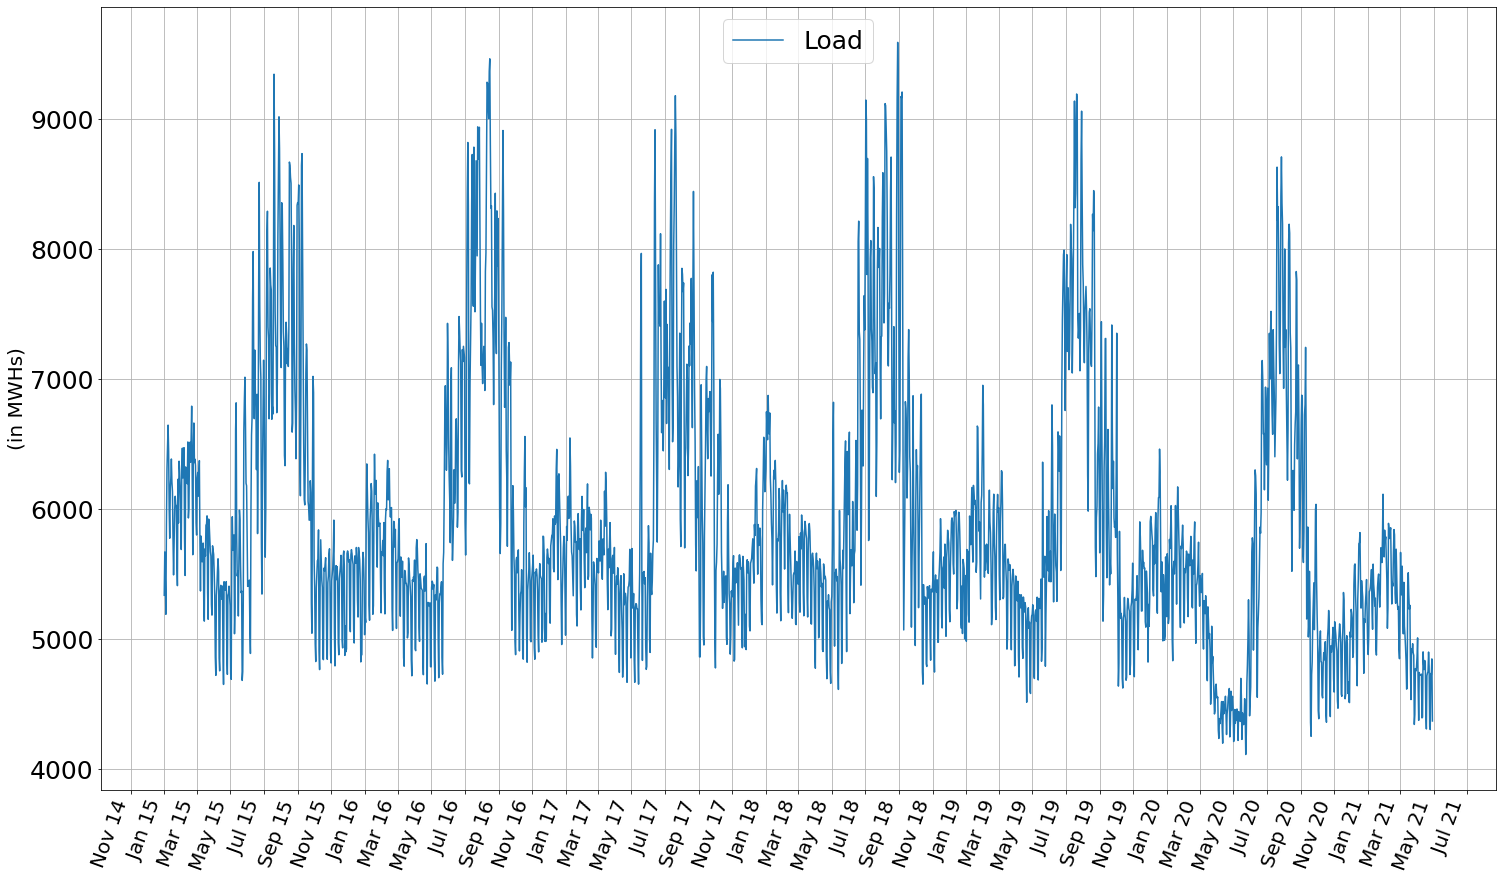

In [11]:
fig,ax = plt.subplots(figsize=(25,16))
ax.plot(df_day_filter,linewidth=1.5)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.gcf().autofmt_xdate()

ax.patch.set_facecolor('blue')
ax.patch.set_alpha(0.0)
plt.yticks(fontsize=25)
plt.xticks(fontsize=20,rotation = 70)
plt.xlabel('')
plt.ylabel('(in MWHs)',fontsize=20)
ax.grid()
plt.use_sticky_edges = False
plt.margins()
plt.legend(['Load'],loc = 'upper center',fontsize=25)

plt.show()

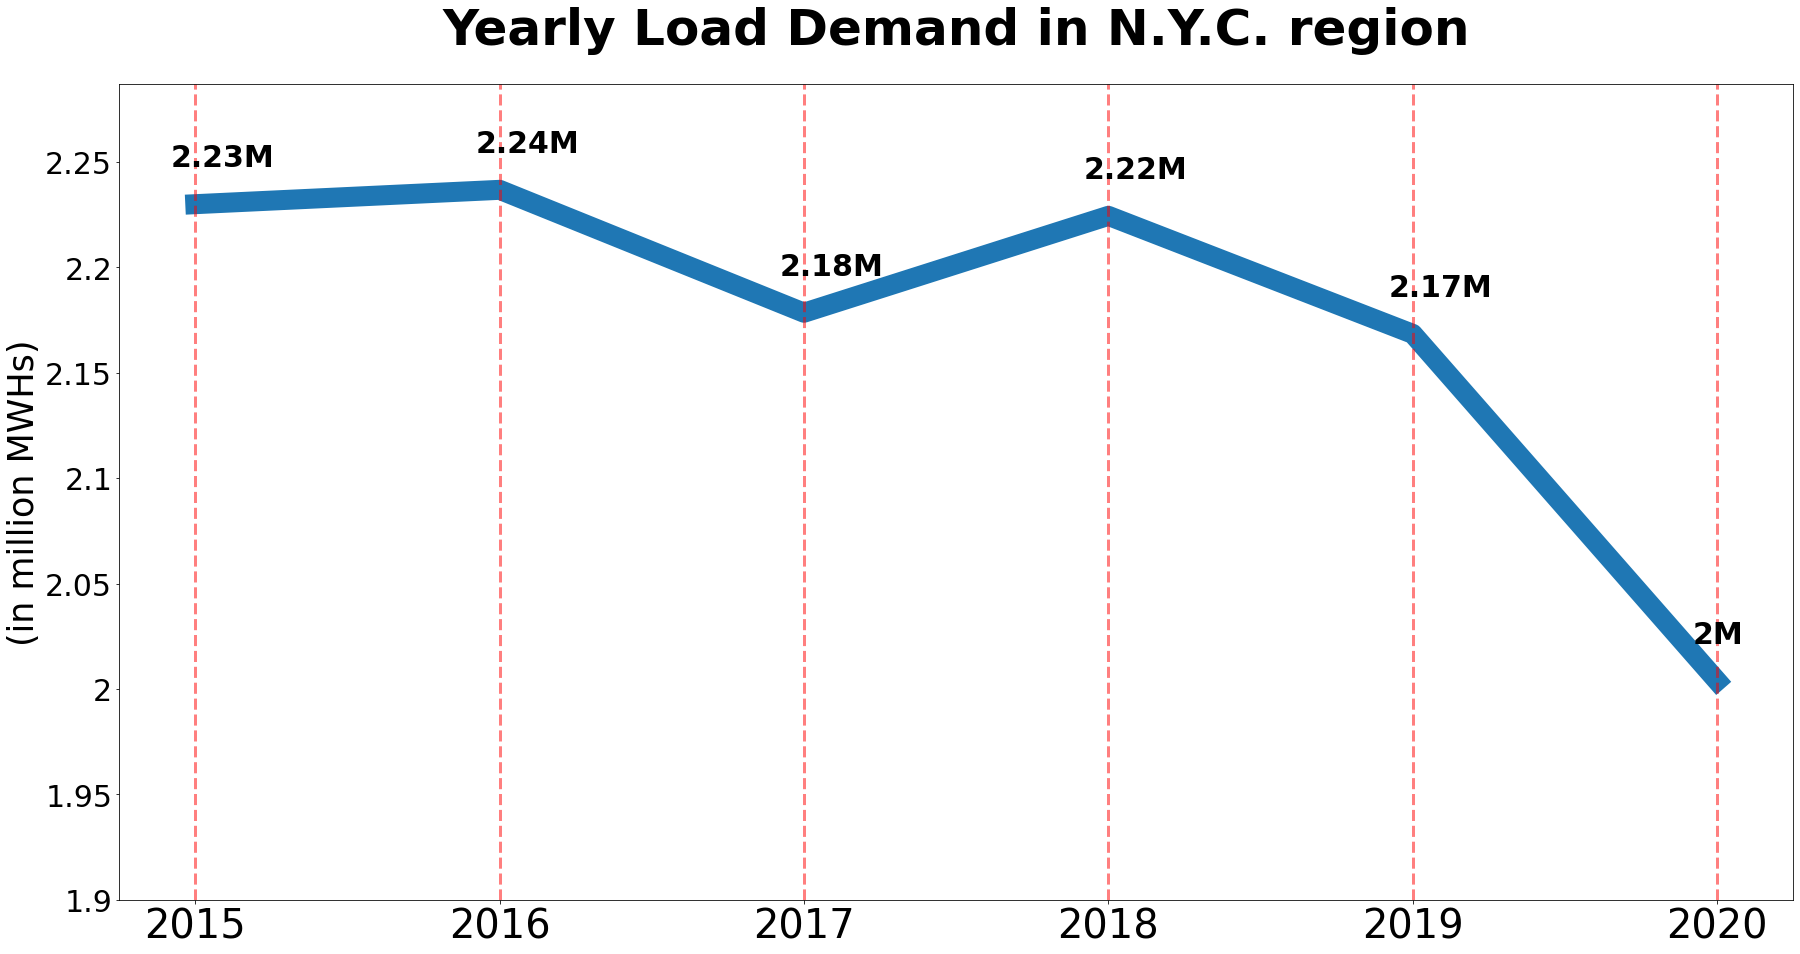

In [12]:
import matplotlib.ticker as ticker
fig, ax=plt.subplots(figsize=(30,15))
ax.patch.set_facecolor('blue')
ax.patch.set_alpha(0.0)

ax.plot(list(df_load.resample('D').mean().resample('Y').sum().index.year[:-1]), 
        list(df_load.resample('D').mean().resample('Y').sum()['load'][:-1]),linewidth=20)
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
for yr in list(df_load.resample('D').mean().resample('Y').sum().index.year[:-1]):
    ax.axvline(yr, color ="red", linestyle = "--", alpha = 0.5,linewidth=3)

for year_i, num in zip(list(df_load.resample('D').mean().resample('Y').sum().index.year[:-1]),
                       list(df_load.resample('D').mean().resample('Y').sum()['load'][:-1])):
    ax.annotate(text="{0:.3g}M".format(num/1000000),xy=(year_i,num),fontsize=30, xytext=(year_i-0.08,num+18000),
                fontweight="bold")

plt.ylim(top =int(max(list(df_load.resample('D').mean().resample('Y').sum()['load']))+50000))
plt.ylim(bottom = 1900000 )
plt.yticks(fontsize=30)
plt.xticks(fontsize=40)
ax.set_ylabel('(in million MWHs)', fontsize = 35)
plt.title('Yearly Load Demand in N.Y.C. region',fontsize=50,pad=40,fontweight="bold")

plt.show()

#### creating new dataframe

In [13]:
new_dates = [str(x) for x in df_day_filter.index.date]

In [14]:
load_new = list(df_day_filter.load)

In [15]:
new_df = pd.DataFrame(data=load_new,index=new_dates,columns=['load'])

In [16]:
new_df['diff'] = new_df['load'].diff()

In [17]:
new_df.index = pd.to_datetime(new_df.index)

In [18]:
new_df.head()

,load,diff
2015-01-01,5338.136934,NaN
2015-01-02,5671.767014,333.630080
2015-01-03,5419.543836,-252.223178
2015-01-04,5191.942857,-227.600978
2015-01-05,5879.011644,687.068787


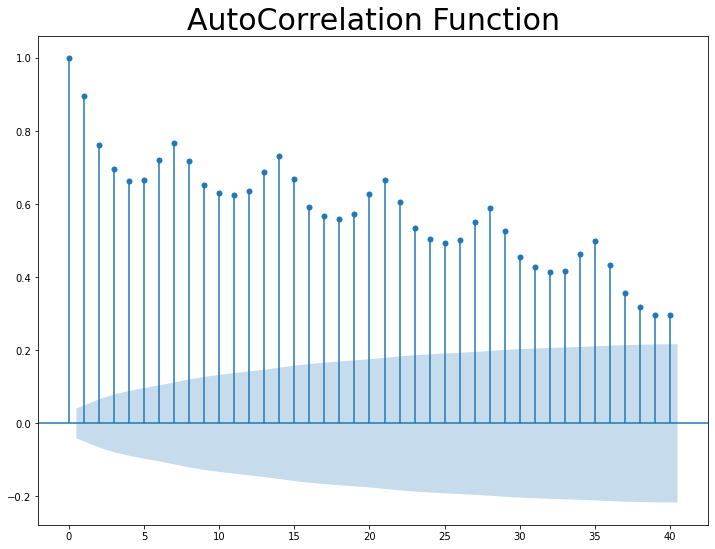

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12,9))

plot_acf(new_df.load.values, lags=40, ax=ax)
plt.title('AutoCorrelation Function',fontsize=30)
plt.show()

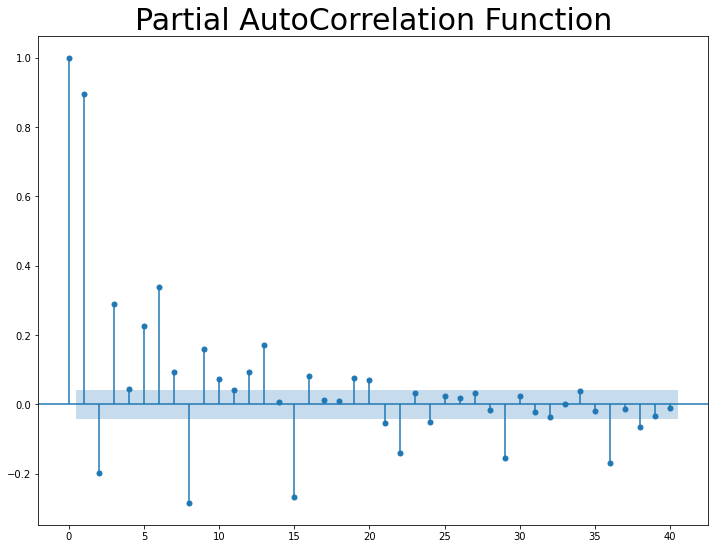

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,9))
plot_pacf(new_df.load.values, lags=40, ax=ax)
plt.title('Partial AutoCorrelation Function',fontsize=30)
plt.show()

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff_1 = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff_1.append(value)
    return pd.Series(diff_1)

In [ ]:
# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

### Extracting Weather Data

In [35]:
#initialize dates
dates= []
max_temps = []
min_temps = []
prcp = []

#make the api call
start_year = input('Start Year: ' )
end_year = input('End Year: ' )

for year in range(int(start_year),int(end_year)+1):
    for month in range(1,13):
        time.sleep(0.3)
        num_days = monthrange(year, month)[1]
        try:
            if len(str(month)) == 2:
                r = requests.get(f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid={data_type}&limit=1000&stationid={station_id}&startdate={str(year)}-{str(month)}-01&enddate={str(year)}-{str(month)}-{str(num_days)}', headers={'token':Token})
            else:
                r = requests.get(f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid={data_type}&limit=1000&stationid={station_id}&startdate={year}-0{str(month)}-01&enddate={str(year)}-0{str(month)}-{str(num_days)}', headers={'token':Token})

            #load the api response as json
            d = json.loads(r.text)

            #organize in a list
            date = [item['date'].split('T')[0] for item in d['results'] if item['datatype'] == 'PRCP']
            precip = [item['value'] for item in d['results'] if item['datatype'] == 'PRCP']
            tmax = [round(float(item['value'])/10.0*1.8,1) + 32 for item in d['results'] if item['datatype'] == 'TMAX']
            tmin = [round(float(item['value'])/10.0*1.8,1) + 32 for item in d['results'] if item['datatype'] == 'TMIN']

            #append in the list
            dates += date
            prcp += precip
            max_temps += tmax
            min_temps += tmin
        except:
            continue

Start Year: 2015
End Year: 2021


In [36]:
df_weather = pd.DataFrame()

In [37]:
df_weather['dates'] = dates
df_weather['max_temp'] = max_temps
df_weather['min_temp'] = min_temps
df_weather['precip'] = prcp

In [38]:
df_weather['dates'] = pd.to_datetime(df_weather[df_weather.columns[0]])

In [39]:
df_weather.head(5)

,dates,max_temp,min_temp,precip
0,2015-01-01,39.0,27.1,0
1,2015-01-02,42.1,35.1,0
2,2015-01-03,42.1,33.1,180
3,2015-01-04,55.9,41.0,76
4,2015-01-05,48.9,21.2,0


In [40]:
df_weather['avg_temp'] = (df_weather['max_temp'] + df_weather['min_temp'])/2

In [41]:
df_weather.head()

,dates,max_temp,min_temp,precip,avg_temp
0,2015-01-01,39.0,27.1,0,33.05
1,2015-01-02,42.1,35.1,0,38.60
2,2015-01-03,42.1,33.1,180,37.60
3,2015-01-04,55.9,41.0,76,48.45
4,2015-01-05,48.9,21.2,0,35.05


In [42]:
df_weather.drop('precip',axis=1,inplace=True)

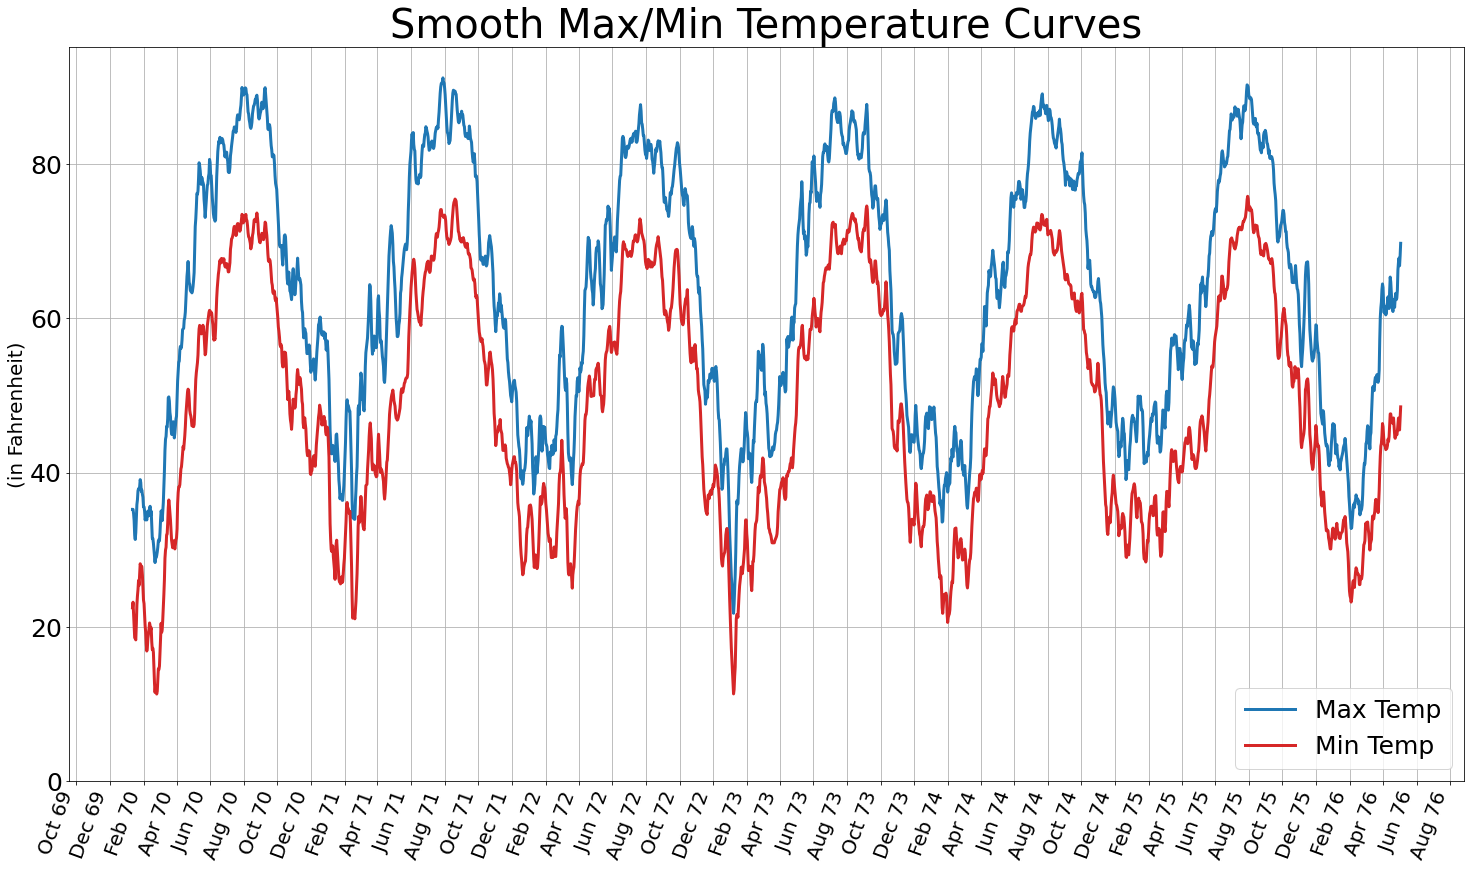

In [45]:
import matplotlib.dates as mdates


ax = df_weather['max_temp'].rolling(11).mean().plot(figsize=(25,15), linewidth = 3, label='MA Max Temp' )

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.gcf().autofmt_xdate()

ax.patch.set_facecolor('blue')
ax.patch.set_alpha(0.0)

plt.plot(df_weather['min_temp'].rolling(11).mean(),'tab:red', linewidth = 3, label='MA Min Temp')

plt.yticks(fontsize=25)
plt.xticks(fontsize=20,rotation = 70)
plt.xlabel('')
plt.ylabel('(in Fahrenheit)',fontsize=20)
ax.grid()
plt.use_sticky_edges = False

plt.ylim(bottom = 0)

plt.title('Smooth Max/Min Temperature Curves',fontsize=40)
plt.legend(['Max Temp','Min Temp'],loc = 'lower right',fontsize=25)

plt.show()